In [1]:
!pip install opencv-python
!pip install mediapipe
!pip install numpy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ---------------- ----------------------- 6.6/15.8 MB 31.0 MB/s eta 0:00:01
   -------------------------------- ------- 12.8/15.8 MB 30.9 MB/s eta 0:00:01
   ---------------------------------------- 15.8/15.8 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.1
    Uninstalling numpy-2.3.1:
      Successfully uninstalled numpy-2.3.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
import mediapipe as mp
import numpy as np
import time

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

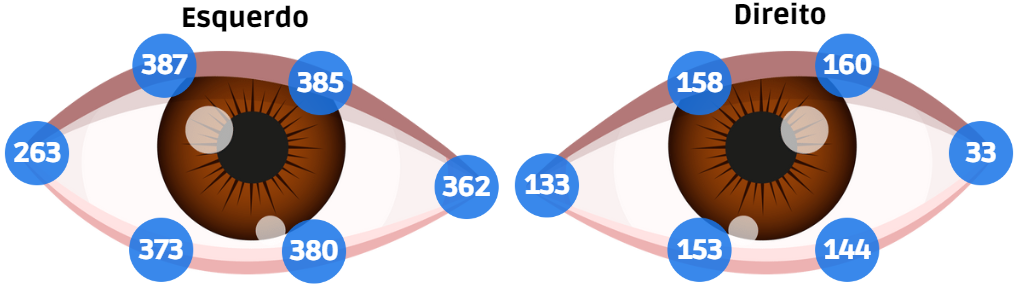

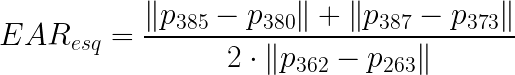
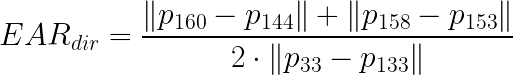

In [4]:
p_left_eye = [385, 380, 387, 373, 362, 263]
p_right_eye = [160, 144, 158, 153, 33, 133]

p_eyes = p_left_eye + p_right_eye

In [5]:
def calculate_ear(face, p_right_eye, p_left_eye):
    try:
        face = np.array([[coord.x, coord.y] for coord in face])
        face_left = face[p_left_eye,:]
        face_right = face[p_right_eye,:]

        # calculando distância *euclidiana* a partir da fórmula EAR
        ear_left = (np.linalg.norm(face_left[0] - face_left[1]) + np.linalg.norm(face_left[2] - face_left[3])) / (2 * (np.linalg.norm(face_left[4] - face_left[5])))
        ear_right = (np.linalg.norm(face_right[0] - face_right[1]) + np.linalg.norm(face_right[2] - face_right[3])) / (2 * (np.linalg.norm(face_right[4] - face_right[5])))
    except:
        ear_left = 0.0
        ear_right = 0.0
    mean_ear = (ear_left + ear_right)/2
    return mean_ear

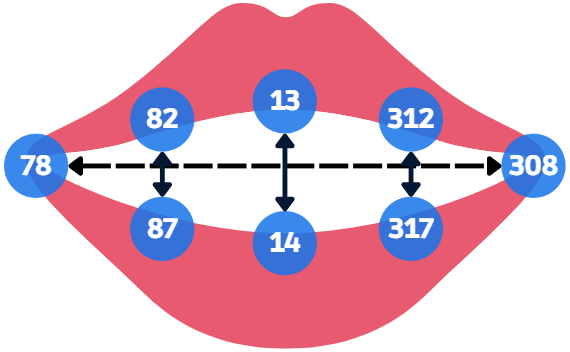

In [6]:
p_mouth = [82, 87, 13, 14, 312, 317, 78, 308]

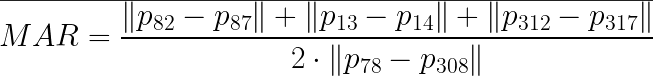

In [7]:
def calculate_mar(face, p_mouth):
    try:
        face = np.array([[coord.x, coord.y] for coord in face])
        face_mouth = face[p_mouth,:]

        mar = (np.linalg.norm(face_mouth[0] - face_mouth[1]) + np.linalg.norm(face_mouth[2] - face_mouth[3]) + np.linalg.norm(face_mouth[4] - face_mouth[5])) / (2 * (np.linalg.norm(face_mouth[6] - face_mouth[7])))
    except:
        mar = 0.0
    return mar

In [8]:
ear_limiar = 0.25
mar_limiar = 0.1
sleeping = 0
blink_count = 0

cam = cv2.VideoCapture(0)

with mp_face_mesh.FaceMesh(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as facemesh:
    while cam.isOpened():
        success, frame = cam.read()
        if not success:
            print("ignoring empty frame")
            continue
        length, width, _ = frame.shape

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result_facemesh = facemesh.process(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        try:
            for face_landmarks in result_facemesh.multi_face_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    face_landmarks,
                    mp_face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec = mp_drawing.DrawingSpec(color=(255, 199, 255), thickness=1, circle_radius=1),
                    connection_drawing_spec = mp_drawing.DrawingSpec(color=(250, 155, 255), thickness=1, circle_radius=1))
                face = face_landmarks.landmark

                for id_coord, coord_xyz in enumerate(face):
                    # coordenadas dos olhos
                    if id_coord in p_eyes:
                        coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x, coord_xyz.y, width, length)
                        cv2.circle(frame, coord_cv, 2, (191, 8, 112), -1)
                    # coordenadas da boca
                    if id_coord in p_mouth:
                        coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x, coord_xyz.y, width, length)
                        cv2.circle(frame, coord_cv, 2, (191, 8, 112), -1)

                ear = calculate_ear(face, p_right_eye, p_left_eye)
                cv2.rectangle(frame, (0,1), (285,106), (255,227,250), -1)
                cv2.putText(frame, f"EAR: {round(ear, 2):.2f} {'Opened' if ear >= ear_limiar else 'Closed'}" , (1, 24), # arredonda e deixa com 2 casas decimais
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (176, 0, 144), 1)
                
                mar = calculate_mar(face, p_mouth)
                cv2.putText(frame, f"MAR: {round(mar, 2):.2f} {'Opened' if mar >= mar_limiar else 'Closed'}" , (1, 50), 
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (176, 0, 144), 1)

                if ear < ear_limiar and mar < mar_limiar:
                    if sleeping == 0:
                        t_initial = time.time()
                        blink_count = blink_count + 1
                    else:
                        t_initial
                        blink_count
                    sleeping = 1
                if (sleeping == 1 and ear >= ear_limiar) or (ear <= ear_limiar and mar >= mar_limiar):
                    sleeping = 0
                t_final = time.time()
                
                cv2.putText(frame, f"Blinks: {blink_count}" , (1, 102), 
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (176, 0, 144), 1)
                if sleeping == 1:
                    tempo = (t_final - t_initial)
                else:
                    tempo = 0.0
                cv2.putText(frame, f"Time: {round(tempo, 3):.3f}" , (1, 76), 
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (176, 0, 144), 1)
        
        except:
            pass

        cv2.imshow("Camera", frame)
        if(cv2.waitKey(10) & 0xFF == ord('c')):
            break

cam.release()
cv2.destroyAllWindows()